In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('json')

import matplotlib.pyplot as plt

from metpy.calc import add_height_to_pressure
from metpy.units import units
import sys
sys.path.append('../splash/')
import functions_library

# Open SOS Measurement Dataset

In [2]:
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df_5Min = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
tidy_df_30Min = pd.read_parquet(f'tidy_df_30min_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# convert time column to datetime
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df_5Min = tidy_df_5Min.set_index('time').sort_index().loc[start_date:end_date].reset_index()

# Open Turbpy Model Ensemble Dataset

In [3]:
model_df = pd.read_parquet("model_results_test.parquet")
# add a bunch of columns that are descriptive, from the config column which has multiple bits of info
model_df['z0'] = model_df['config'].apply(
    lambda v: v.split(' ')[-1]
)
model_df['e_sat_curve'] = model_df['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)
model_df['surface_measurement'] = model_df['config'].apply(
    lambda v: v.split(' ')[-3]
)
model_df['scheme'] = model_df['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df['most_config'] = model_df['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df['most_config'] = model_df['most_config'].str.replace(' andreas lengths', '')

model_df['time'] = model_df['time'].dt.tz_localize('US/Mountain')
model_df.head()

,time,config,latent heat flux,sensible heat flux,zeta,latent heat conductance,sensible heat conductance,z0,e_sat_curve,surface_measurement,scheme,most_config
0,2022-11-30 00:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000287,-0.011176,0.031890,2834700.0,0.002104,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
1,2022-11-30 00:30:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000279,-0.008654,0.044341,2834700.0,0.002677,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
2,2022-11-30 01:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000503,-0.004272,0.037185,2834700.0,0.002563,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
3,2022-11-30 01:30:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000376,-0.004802,0.071018,2834700.0,0.001932,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
4,2022-11-30 02:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000035,-0.011543,0.054712,2834700.0,0.002313,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin


In [4]:
model_df

,time,config,latent heat flux,sensible heat flux,zeta,latent heat conductance,sensible heat conductance,z0,e_sat_curve,surface_measurement,scheme,most_config
0,2022-11-30 00:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000287,-0.011176,0.031890,2834700.0,0.002104,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
1,2022-11-30 00:30:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000279,-0.008654,0.044341,2834700.0,0.002677,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
2,2022-11-30 01:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000503,-0.004272,0.037185,2834700.0,0.002563,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
3,2022-11-30 01:30:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000376,-0.004802,0.071018,2834700.0,0.001932,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
4,2022-11-30 02:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000035,-0.011543,0.054712,2834700.0,0.002313,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
...,...,...,...,...,...,...,...,...,...,...,...,...
43,2022-11-30 21:30:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,-0.003496,-0.049363,0.514499,2834700.0,0.001347,0.005,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
44,2022-11-30 22:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,-0.004408,-0.065996,0.414150,2834700.0,0.001423,0.005,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
45,2022-11-30 22:30:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,-0.002510,-0.042034,0.475148,2834700.0,0.001397,0.005,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
46,2022-11-30 23:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,-0.000116,-0.037942,0.195252,2834700.0,0.001719,0.005,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin


In [4]:
model_df_variable_z0 = pd.read_parquet("model_results_w_variable_z0.parquet")
# add a bunch of columns that are descriptive, from the config column which has multiple bits of info
model_df_variable_z0['z0'] = model_df_variable_z0['config'].apply(
    lambda v: v.split(' ')[-1]
)
model_df_variable_z0['e_sat_curve'] = model_df_variable_z0['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)
model_df_variable_z0['surface_measurement'] = model_df_variable_z0['config'].apply(
    lambda v: v.split(' ')[-3]
)
model_df_variable_z0['scheme'] = model_df_variable_z0['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df_variable_z0['most_config'] = model_df_variable_z0['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df_variable_z0['most_config'] = model_df_variable_z0['most_config'].str.replace(' andreas lengths', '')

model_df_variable_z0['time'] = model_df_variable_z0['time'].dt.tz_localize('US/Mountain')

model_df_variable_z0.head()

,time,config,latent heat flux,sensible heat flux,zeta,latent heat conductance,sensible heat conductance,z0,e_sat_curve,surface_measurement,scheme,most_config
0,2022-11-30 00:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000278,-0.003740,0.026087,2834700.0,0.002067,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
1,2022-11-30 00:30:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000174,-0.005148,0.166125,2834700.0,0.002000,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
2,2022-11-30 01:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000326,-0.001679,0.074633,2834700.0,0.002265,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
3,2022-11-30 01:30:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000271,-0.001992,0.056988,2834700.0,0.001673,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin
4,2022-11-30 02:00:00-07:00,MO Holtslag de Bruin andreas lengths Tsurf_c e...,0.000025,-0.004289,0.279131,2834700.0,0.001857,z0_andreas,alduchov,Tsurf_c,andreas,MO Holtslag de Bruin


combine the dataset of model results with constant z0 values and the results with variable z0 values

In [5]:
model_df = pd.concat([
    model_df,
    model_df_variable_z0  
])

### Handle a pesky outlier

In [6]:
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'latent heat flux'] = 0
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'sensible heat flux'] = 0

# Run the COARE/ANDREAS model (with multiple z0 configurations)

## Prepare the z0 data

In [7]:
# z0 values calculated using the andreas method
z0_andreas_df = pd.read_parquet("z0estimates/z0_andreas_df.parquet")[['time', 'z0']]
z0_andreas_df_weekly = pd.read_parquet("z0estimates/z0_andreas_df_weekly.parquet")[['time', 'z0']]
# z0 values calculated using the log-profile during neutral conditions
# z0_df = pd.read_parquet("z0estimates/z0_df.parquet")
z0_df_weekly = pd.read_parquet("z0estimates/z0_df_weekly.parquet").rename(columns={
    'z0_3m_c': 'z0'
})

# apply ceiling to z0 values
z0_andreas_df_weekly['z0'] = z0_andreas_df_weekly['z0'].apply(lambda z0: 0.01 if z0 > 0.01 else z0)
z0_andreas_df['z0'] = z0_andreas_df['z0'].apply(lambda z0: 0.01 if z0 > 0.01 else z0)
z0_df_weekly['z0'] = z0_df_weekly['z0'].apply(lambda z0: 0.01 if z0 > 0.01 else z0)

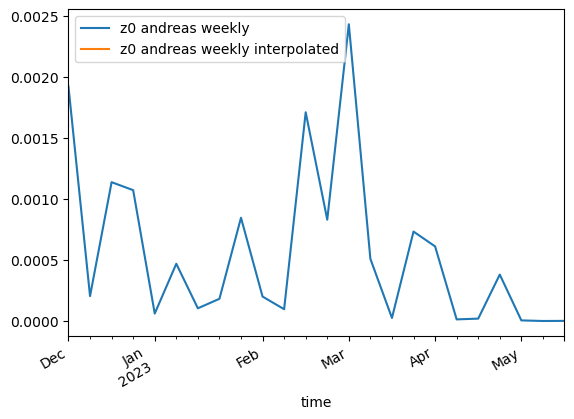

In [8]:
# reindex the weekly data so theres a data point for each 30min time step
z0_andreas_df_weekly.set_index('time')['z0'].plot(label='z0 andreas weekly')
z0_andreas_df_weekly = z0_andreas_df_weekly.set_index('time').reindex(z0_andreas_df.time, method='bfill')
z0_andreas_df_weekly['z0'].plot(label='z0 andreas weekly interpolated')
plt.legend()

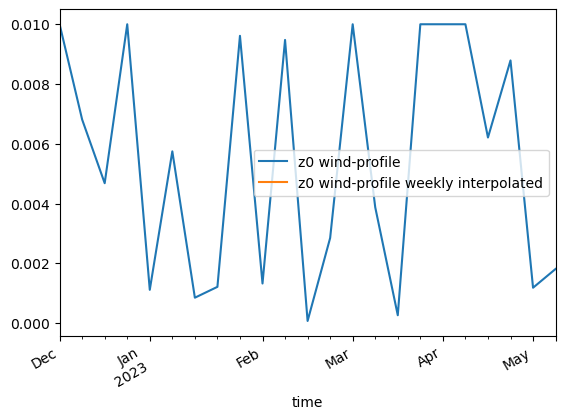

In [9]:
z0_df_weekly.set_index('time')['z0'].plot(label='z0 wind-profile')
z0_df_weekly = z0_df_weekly.set_index('time').reindex(z0_andreas_df.time, method='bfill')
z0_df_weekly['z0'].plot(label='z0 wind-profile weekly interpolated')
plt.legend()

In [10]:
# combine the 3 types of z0 values into a single DF
#   1. andreas per-timestep calculations
#   2. andreas weekly averages
#   3. simple/wind-profile weekly averages
z0_df = z0_andreas_df.set_index('time').join(
    z0_andreas_df_weekly.rename(columns={'z0':'z0_weekly'})
).join(
    z0_df_weekly.rename(columns={'z0':'z0_weekly_windprofile'})
)
# fill missing windprofile z0 values on the last day
z0_df['z0_weekly_windprofile'] = z0_df['z0_weekly_windprofile'].ffill()

In [11]:
z0_df.head(3)

,z0,z0_weekly,z0_weekly_windprofile
time,,,
2022-11-29 17:02:30,0.01000,0.001919,0.01
2022-11-29 17:07:30,0.01000,0.001919,0.01
2022-11-29 17:12:30,0.00661,0.001919,0.01


In [12]:
INVERSION_HEIGHT = 600
SOS_INSTRUMENT_HEIGHT = 3

sos_inputs_df = tidy_df_30Min[tidy_df_30Min.variable.isin(
    ['spd_3m_c', 'Tsurf_c', 'T_3m_c', 'RH_3m_c', 'mixingratio_3m_c', 'P_10m_c', 'SnowDepth_d', 'w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c', 'w_tc__3m_c']
)][['time', 'variable', 'value']].set_index('time').pivot(columns='variable')
sos_inputs_df.columns = sos_inputs_df.columns.droplevel()
# adjust pressure from 10m to 3m
sos_inputs_df['P_10m_c'] = add_height_to_pressure(
    sos_inputs_df['P_10m_c'].values * units("millibar"), 
    -7 * units("m")
)

# add in the `z0` columns
sos_inputs_df = sos_inputs_df.join(
    z0_df
)

output_var_names = [
    'hsb', 'hlb', 'tau', 'zo', 'zot', 'zoq', 'L', 'usr', 'tsr', 'qsr', 'dter', 'dqer', \
        'hl_webb', 'Cd', 'Ch', 'Ce', 'Cdn_10', 'Chn_10', 'Cen_10', 'rr', 'rt', 'rq', 
]

sos_results_list_z0_00001 = []
sos_results_list_z0_00005 = []
sos_results_list_z0_0001 = []
sos_results_list_z0_0005 = []
sos_results_list_z0_001 = []
sos_results_list_z0_005 = []
sos_results_list_with_z0 = []
sos_results_list_with_z0_weekly = []
sos_results_list_with_z0_weekly_windprofile = []
for time, row in sos_inputs_df.iterrows():
    bulk_inputs = [
        row['spd_3m_c'],
        row['Tsurf_c'],
        row['T_3m_c'],
        row['mixingratio_3m_c'],
        INVERSION_HEIGHT,
        row['P_10m_c'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d'],
        row['RH_3m_c'],
        1 # vwc "volumetric water content" doesn't matter if snow_flag = 1
    ]
    if any(pd.isnull(np.array(bulk_inputs))):
        print(f"Failed on timestamp: {time}")
        nan_filler = np.full(len(output_var_names), np.nan)
        # runs with constant z0 values
        sos_results_list_z0_00001.append(nan_filler)
        sos_results_list_z0_00005.append(nan_filler)
        sos_results_list_z0_0001.append(nan_filler)
        sos_results_list_z0_0005.append(nan_filler)
        sos_results_list_z0_001.append(nan_filler)
        sos_results_list_z0_005.append(nan_filler)
        # runs with variable z0 values
        sos_results_list_with_z0.append(nan_filler)
        sos_results_list_with_z0_weekly.append(nan_filler)
        sos_results_list_with_z0_weekly_windprofile.append(nan_filler)
    else:
        # runs with constant z0 values
        bulk_outputs_z0_00001 = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=0.00001)
        bulk_outputs_z0_00005 = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=0.00005)
        bulk_outputs_z0_0001 = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=0.0001)
        bulk_outputs_z0_0005 = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=0.0005)
        bulk_outputs_z0_001 = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=0.001)
        bulk_outputs_z0_005 = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=0.005)
        # runs with variable z0 values
        bulk_outputs_with_z0 = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=row['z0'])
        bulk_outputs_with_z0_weekly = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=row['z0_weekly'])
        bulk_outputs_with_z0_weekly_windprofile = functions_library.cor_ice_A10(bulk_inputs, le_flag=1,snow_flag=1,sta='asfs30', snow_z0=row['z0_weekly_windprofile'])
        
        # runs with constant z0 values
        sos_results_list_z0_00001.append(bulk_outputs_z0_00001)
        sos_results_list_z0_00005.append(bulk_outputs_z0_00005)
        sos_results_list_z0_0001.append(bulk_outputs_z0_0001)
        sos_results_list_z0_0005.append(bulk_outputs_z0_0005)
        sos_results_list_z0_001.append(bulk_outputs_z0_001)
        sos_results_list_z0_005.append(bulk_outputs_z0_005)
        # runs with variable z0 values
        sos_results_list_with_z0.append(bulk_outputs_with_z0)
        sos_results_list_with_z0_weekly.append(bulk_outputs_with_z0_weekly)
        sos_results_list_with_z0_weekly_windprofile.append(bulk_outputs_with_z0_weekly_windprofile)


# AGGREGATE THE RESULTS INTO DATAFRAMES
# runs with constant z0 values
sos_results_z0_00001_df = pd.DataFrame(sos_results_list_z0_00001)
sos_results_z0_00001_df.columns = output_var_names
sos_results_z0_00001_df['time'] = sos_inputs_df.index
sos_results_z0_00001_df = sos_results_z0_00001_df.set_index('time')

sos_results_z0_00005_df = pd.DataFrame(sos_results_list_z0_00005)
sos_results_z0_00005_df.columns = output_var_names
sos_results_z0_00005_df['time'] = sos_inputs_df.index
sos_results_z0_00005_df = sos_results_z0_00005_df.set_index('time')

sos_results_z0_0001_df = pd.DataFrame(sos_results_list_z0_0001)
sos_results_z0_0001_df.columns = output_var_names
sos_results_z0_0001_df['time'] = sos_inputs_df.index
sos_results_z0_0001_df = sos_results_z0_0001_df.set_index('time')

sos_results_z0_0005_df = pd.DataFrame(sos_results_list_z0_0005)
sos_results_z0_0005_df.columns = output_var_names
sos_results_z0_0005_df['time'] = sos_inputs_df.index
sos_results_z0_0005_df = sos_results_z0_0005_df.set_index('time')

sos_results_z0_001_df = pd.DataFrame(sos_results_list_z0_001)
sos_results_z0_001_df.columns = output_var_names
sos_results_z0_001_df['time'] = sos_inputs_df.index
sos_results_z0_001_df = sos_results_z0_001_df.set_index('time')

sos_results_z0_005_df = pd.DataFrame(sos_results_list_z0_005)
sos_results_z0_005_df.columns = output_var_names
sos_results_z0_005_df['time'] = sos_inputs_df.index
sos_results_z0_005_df = sos_results_z0_005_df.set_index('time')

# runs with variable z0 values
sos_results_with_z0_df = pd.DataFrame(sos_results_list_with_z0)
sos_results_with_z0_df.columns = output_var_names
sos_results_with_z0_df['time'] = sos_inputs_df.index
sos_results_with_z0_df = sos_results_with_z0_df.set_index('time')

sos_results_with_z0_weekly_df = pd.DataFrame(sos_results_list_with_z0_weekly)
sos_results_with_z0_weekly_df.columns = output_var_names
sos_results_with_z0_weekly_df['time'] = sos_inputs_df.index
sos_results_with_z0_weekly_df = sos_results_with_z0_weekly_df.set_index('time')

sos_results_with_z0_weekly_windprofile_df = pd.DataFrame(sos_results_list_with_z0_weekly_windprofile)
sos_results_with_z0_weekly_windprofile_df.columns = output_var_names
sos_results_with_z0_weekly_windprofile_df['time'] = sos_inputs_df.index
sos_results_with_z0_weekly_windprofile_df = sos_results_with_z0_weekly_windprofile_df.set_index('time')

## Convert w/m^2 to g/m^2/s
latent_heat_of_vaporization = 2838 * units("J/g")
sos_results_z0_00001_df['hlb_gperm2s'] = sos_results_z0_00001_df['hlb'] / latent_heat_of_vaporization
sos_results_z0_00005_df['hlb_gperm2s'] = sos_results_z0_00005_df['hlb'] / latent_heat_of_vaporization
sos_results_z0_0001_df['hlb_gperm2s'] = sos_results_z0_0001_df['hlb'] / latent_heat_of_vaporization
sos_results_z0_0005_df['hlb_gperm2s'] = sos_results_z0_0005_df['hlb'] / latent_heat_of_vaporization
sos_results_z0_001_df['hlb_gperm2s'] = sos_results_z0_001_df['hlb'] / latent_heat_of_vaporization
sos_results_z0_005_df['hlb_gperm2s'] = sos_results_z0_005_df['hlb'] / latent_heat_of_vaporization
sos_results_with_z0_df['hlb_gperm2s'] = sos_results_with_z0_df['hlb'] / latent_heat_of_vaporization
sos_results_with_z0_weekly_df['hlb_gperm2s'] = sos_results_with_z0_weekly_df['hlb'] / latent_heat_of_vaporization
sos_results_with_z0_weekly_windprofile_df['hlb_gperm2s'] = sos_results_with_z0_weekly_windprofile_df['hlb'] / latent_heat_of_vaporization

Failed on timestamp: 2023-01-17 08:00:00
Failed on timestamp: 2023-01-17 08:30:00
Failed on timestamp: 2023-01-17 09:00:00
Failed on timestamp: 2023-01-17 09:30:00
Failed on timestamp: 2023-01-17 10:00:00
Failed on timestamp: 2023-01-17 10:30:00
Failed on timestamp: 2023-01-17 11:00:00
Failed on timestamp: 2023-01-17 11:30:00
Failed on timestamp: 2023-01-17 12:00:00
Failed on timestamp: 2023-01-17 12:30:00
Failed on timestamp: 2023-01-17 13:00:00
Failed on timestamp: 2023-03-11 00:00:00
Failed on timestamp: 2023-03-11 00:30:00
Failed on timestamp: 2023-03-11 01:00:00
Failed on timestamp: 2023-03-11 01:30:00
Failed on timestamp: 2023-03-11 02:00:00
Failed on timestamp: 2023-03-11 02:30:00
Failed on timestamp: 2023-03-11 03:00:00
Failed on timestamp: 2023-03-11 03:30:00
Failed on timestamp: 2023-03-11 04:00:00
Failed on timestamp: 2023-03-11 04:30:00
Failed on timestamp: 2023-03-11 05:00:00
Failed on timestamp: 2023-03-11 05:30:00
Failed on timestamp: 2023-03-11 06:00:00
Failed on timest

## Peak at the results

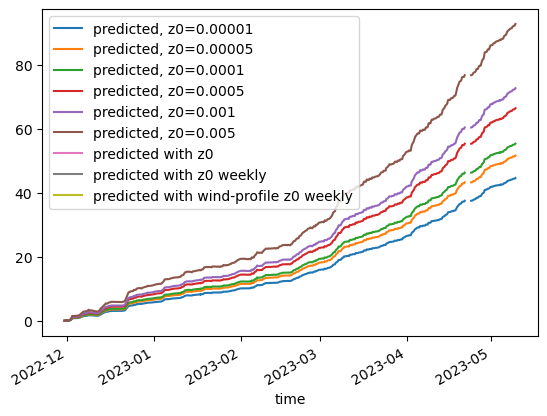

In [13]:
seconds_in_sos_timestep = 30*60
from metpy.constants import density_water
import matplotlib.pyplot as plt
((sos_results_z0_00001_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted, z0=0.00001'
)
((sos_results_z0_00005_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted, z0=0.00005'
)
((sos_results_z0_0001_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted, z0=0.0001'
)
((sos_results_z0_0005_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted, z0=0.0005'
)
((sos_results_z0_001_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted, z0=0.001'
)
((sos_results_z0_005_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted, z0=0.005'
)


((sos_results_with_z0_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted with z0'
)
((sos_results_with_z0_weekly_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted with z0 weekly'
)
((sos_results_with_z0_weekly_windprofile_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum()*seconds_in_sos_timestep/density_water).plot(
    label = 'predicted with wind-profile z0 weekly'
)
plt.legend()

In [38]:
new_df.config.unique()

array(['Tsurf_c e_sat_alduchov z0_andreas',
       'Tsurf_d e_sat_alduchov z0_andreas',
       'Tsurf_rad_d e_sat_alduchov z0_andreas',
       'Tsurf_c e_sat_alduchov z0_andreas_weekly',
       'Tsurf_d e_sat_alduchov z0_andreas_weekly',
       'Tsurf_rad_d e_sat_alduchov z0_andreas_weekly',
       'Tsurf_c e_sat_alduchov z0_windprofile_weekly',
       'Tsurf_d e_sat_alduchov z0_windprofile_weekly',
       'Tsurf_rad_d e_sat_alduchov z0_windprofile_weekly',
       'Tsurf_c e_sat_alduchov 1e-05', 'Tsurf_d e_sat_alduchov 1e-05',
       'Tsurf_rad_d e_sat_alduchov 1e-05', 'Tsurf_c e_sat_alduchov 5e-05',
       'Tsurf_d e_sat_alduchov 5e-05', 'Tsurf_rad_d e_sat_alduchov 5e-05',
       'Tsurf_c e_sat_alduchov 0.0001', 'Tsurf_d e_sat_alduchov 0.0001',
       'Tsurf_rad_d e_sat_alduchov 0.0001',
       'Tsurf_c e_sat_alduchov 0.0005', 'Tsurf_d e_sat_alduchov 0.0005',
       'Tsurf_rad_d e_sat_alduchov 0.0005',
       'Tsurf_c e_sat_alduchov 0.001', 'Tsurf_d e_sat_alduchov 0.001',
       'Tsur

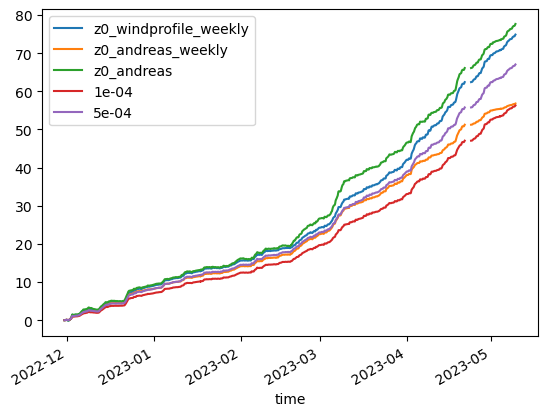

In [49]:
new_df = pd.read_parquet("coare_model_results.parquet")
(
    new_df.query(
        "config == 'Tsurf_c e_sat_alduchov z0_windprofile_weekly'"
    )['hlb_gperm2s']*seconds_in_sos_timestep/density_water    
).cumsum().plot(label="z0_windprofile_weekly")
(
    new_df.query(
        "config == 'Tsurf_c e_sat_alduchov z0_andreas_weekly'"
    )['hlb_gperm2s']*seconds_in_sos_timestep/density_water    
).cumsum().plot(label="z0_andreas_weekly")
(
    new_df.query(
        "config == 'Tsurf_c e_sat_alduchov z0_andreas'"
    )['hlb_gperm2s']*seconds_in_sos_timestep/density_water    
).cumsum().plot(label="z0_andreas")
(
    new_df.query(
        "config == 'Tsurf_c e_sat_alduchov 0.0001'"
    )['hlb_gperm2s']*seconds_in_sos_timestep/density_water    
).cumsum().plot(label="1e-04")
(
    new_df.query(
        "config == 'Tsurf_c e_sat_alduchov 0.0005'"
    )['hlb_gperm2s']*seconds_in_sos_timestep/density_water    
).cumsum().plot(label="5e-04")
plt.legend()

## Combine model runs into a single dataframe

In [ ]:
coare_model_results = pd.concat([
    sos_results_z0_00001_df[['hlb_gperm2s']].assign(z0='0.00001').reset_index(),
    sos_results_z0_00005_df[['hlb_gperm2s']].assign(z0='0.00005').reset_index(),
    sos_results_z0_0001_df[['hlb_gperm2s']].assign(z0='0.0001').reset_index(),
    sos_results_z0_0005_df[['hlb_gperm2s']].assign(z0='0.0005').reset_index(),
    sos_results_z0_001_df[['hlb_gperm2s']].assign(z0='0.001').reset_index(),
    sos_results_z0_005_df[['hlb_gperm2s']].assign(z0='0.005').reset_index(),
    sos_results_with_z0_df[['hlb_gperm2s']].assign(z0='z0_andreas').reset_index(),
    sos_results_with_z0_weekly_df[['hlb_gperm2s']].assign(z0='z0_andreas_weekly').reset_index(),
    sos_results_with_z0_weekly_windprofile_df[['hlb_gperm2s']].assign(z0='z0_windprofile_weekly').reset_index()
])


# Calculate model run seasonal totals

## for COARE model runs

In [ ]:
coare_seasonal_model_results = pd.DataFrame(pd.concat([
    (sos_results_z0_00001_df[['hlb_gperm2s']].assign(z0='0.00001').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
    (sos_results_z0_00005_df[['hlb_gperm2s']].assign(z0='0.00005').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
    (sos_results_z0_0001_df[['hlb_gperm2s']].assign(z0='0.0001').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
    (sos_results_z0_0005_df[['hlb_gperm2s']].assign(z0='0.0005').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
    (sos_results_z0_001_df[['hlb_gperm2s']].assign(z0='0.001').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
    (sos_results_z0_005_df[['hlb_gperm2s']].assign(z0='0.005').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
    (sos_results_with_z0_df[['hlb_gperm2s']].assign(z0='z0_andreas').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
    (sos_results_with_z0_weekly_df[['hlb_gperm2s']].assign(z0='z0_andreas_weekly').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
    (sos_results_with_z0_weekly_windprofile_df[['hlb_gperm2s']].assign(z0='z0_windprofile_weekly').reset_index().set_index(['time', 'z0'])['hlb_gperm2s'].cumsum()*seconds_in_sos_timestep/density_water).iloc[-2:-1],
])).reset_index().rename(columns={'hlb_gperm2s': 'sublimation (mm)'})

## for TurbPy model runs

In [8]:
from metpy.constants import density_water

In [9]:
model_df_cumsum = pd.DataFrame(model_df.sort_values("time").set_index(
    ["time", "config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"]
).groupby(["config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"])['latent heat flux'].cumsum()).reset_index()
agg_model_df = model_df.set_index('time').sort_index().loc[ : '20230509 17:30:0'].reset_index()
agg_model_df = agg_model_df[[
    'time',
    'config',
    'most_config',
    'z0',
    'e_sat_curve',
    'surface_measurement',
    'scheme',
    'latent heat flux'
]]
agg_model_df['latent heat flux (mm)'] = agg_model_df['latent heat flux']*seconds_in_sos_timestep/density_water
agg_model_cum_df = pd.DataFrame(agg_model_df.sort_values("time").set_index(
    ["time", "config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"]
).groupby(["config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"])['latent heat flux (mm)'].cumsum()).reset_index()
agg_model_cum_df = agg_model_cum_df[agg_model_cum_df.time == agg_model_cum_df.time.max()]
agg_model_cum_df['complexity'] = agg_model_cum_df.most_config.isin(['Standard','Louis b = 12']).apply(lambda is_not_complex: 'bulk' if is_not_complex else 'most')

In [10]:
src = agg_model_cum_df.query("e_sat_curve == 'alduchov'").query("complexity == 'most'").query("scheme == 'andreas'")
print('scheme',  src['scheme'].unique())
print('z0',  src['z0'].unique())
print('e_sat_curve',  src['e_sat_curve'].unique())
print('surface_measurement',  src['surface_measurement'].unique())
print('most_config',  src['most_config'].unique())

scheme ['andreas']
z0 ['z0_andreas_weekly' '0.001' '5e-05' 'z0_windprofile_weekly' '0.0001'
 '1e-05' '0.0005' 'z0_andreas' '0.005']
e_sat_curve ['alduchov']
surface_measurement ['Tsurf_c']
most_config ['MO Holtslag de Bruin']


In [11]:
measured_value = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time')[['value']].cumsum().max().value*seconds_in_sos_timestep/density_water.magnitude
measured_min_value = tidy_df_30Min.query("variable == 'w_h2o__15m_c'").set_index('time')[['value']].cumsum().max().value*seconds_in_sos_timestep/density_water.magnitude
measured_max_value = tidy_df_30Min.query("variable == 'w_h2o__10m_uw'").set_index('time')[['value']].cumsum().max().value*seconds_in_sos_timestep/density_water.magnitude

In [12]:
rules = alt.Chart(src).transform_calculate(
    measured = str(measured_value)
).mark_rule(strokeDash=[3,4], color='grey', opacity=0.25).encode(
    y='measured:Q'
) + alt.Chart(src).transform_calculate(
    measured = str(measured_min_value)
).mark_rule(strokeDash=[3,4], color='grey', opacity=0.25).encode(
    y='measured:Q'
) + alt.Chart(src).transform_calculate(
    measured = str(measured_max_value)
).mark_rule(strokeDash=[3,4], color='grey', opacity=0.25).encode(
    y='measured:Q'
)

# Plot Modeled Seasonal Totals, TurbPy and COARE, constant and variable z0 values

Without variable z0 runs

In [17]:
turbpy_model_results_chart = (alt.Chart(src).mark_tick().encode(
    alt.X("z0:O").sort(),
    alt.XOffset("surface_measurement:N"),
    alt.Y("latent heat flux (mm):Q").scale(zero=False),
    alt.Color("surface_measurement:N"),
    detail='config:N'
)
).properties(width = 300, height = 200, title='SNTHERM Algorithm')

turbpy_model_results_chart

alt.Chart(...)

In [ ]:
coare_model_results_chart = (
alt.Chart(coare_seasonal_model_results).mark_tick(
    thickness = 3,
    color='black'
).transform_filter(
    alt.FieldOneOfPredicate('z0', ['0.00001', '0.00005', '0.0001', '0.0005', '0.001', '0.005'])
).encode(
    alt.X("z0:O").sort([
        '0.00001', '0.00005', '0.0001', '0.0005', '0.001', '0.005'
    ]),
    alt.Y("sublimation (mm):Q").scale(zero=False),
) + rules
).properties(width = 300, height = 200, title = 'COARE Algorithm')

(turbpy_model_results_chart.transform_filter(
    alt.datum.surface_measurement == 'Tsurf_c'
) | coare_model_results_chart).resolve_scale(y='shared').display(renderer='svg')

With variable z0 runs

In [ ]:
turbpy_model_results_chart = (alt.Chart(src).mark_tick().encode(
    alt.X("z0:O").sort([
        '1e-05' , '5e-05', '0.0001',  '0.0005', '0.001', '0.005', 
        'z0_andreas', 'z0_windprofile_weekly', 'z0_andreas_weekly'
    ]),
    alt.XOffset("surface_measurement:N"),
    alt.Y("latent heat flux (mm):Q").scale(zero=False),
    alt.Color("surface_measurement:N"),
    detail='config:N'
) + rules
).properties(width = 300, height = 200, title='SNTHERM Algorithm')

turbpy_model_results_chart

In [ ]:


coare_model_results_chart = (
alt.Chart(coare_seasonal_model_results).mark_tick(
    thickness = 3,
    color='black'
).encode(
    alt.X("z0:O").sort([
        '0.00001', '0.00005', '0.0001', '0.0005', '0.001', '0.005',
       'z0_andreas', 'z0_andreas_weekly', 'z0_windprofile_weekly'
    ]),
    alt.Y("sublimation (mm):Q").scale(zero=False),
) + rules
).properties(width = 300, height = 200, title = 'COARE Algorithm')

(turbpy_model_results_chart.transform_filter(
    alt.datum.surface_measurement == 'Tsurf_c'
) | coare_model_results_chart).resolve_scale(y='shared').display(renderer='svg')

# Combine our 3 sources of information (measured data, turbpy models, COARE models) and compare with Stossel box data

In [ ]:
# COARE
coare_model_results
# TURBPY
model_results_for_stossel_comparison = model_df.query("e_sat_curve == 'alduchov'").query("scheme == 'andreas'").query("surface_measurement == 'Tsurf_c'").query("most_config == 'MO Holtslag de Bruin'")
model_results_for_stossel_comparison = model_results_for_stossel_comparison[['time', 'latent heat flux', 'z0']]
model_results_for_stossel_comparison = model_results_for_stossel_comparison.set_index('time').tz_localize(None).reset_index()

# MEASUREMENTS
measurements_for_stossel_comparison = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time')[['value']].rename(columns={'value': 'measured'})

In [ ]:
lysimeter_data = pd.read_csv("../sos/processed_lysimeter_data.csv")
lysimeter_data['time'] = pd.to_datetime(lysimeter_data['time'])
lysimeter_data['time_previous'] = pd.to_datetime(lysimeter_data['time_previous'])
lysimeter_data.head()

In [ ]:
combined_results_df = pd.DataFrame()
for i, row in lysimeter_data.iterrows():
    tprev = row['time_previous']
    t = row['time'] 
    
    # collect coare data
    this_coare_data = coare_model_results.set_index('time').sort_index().loc[tprev: t].pivot_table(
        index='time',
        values=['hlb_gperm2s'],
        columns='z0'
    )
    this_coare_data.columns = ['coare (z0=' + col + ')' for col in this_coare_data.columns.get_level_values(1)]
    this_coare_data = this_coare_data.sum()
    
    # collect turbpy data
    this_turbpy_data = model_results_for_stossel_comparison.set_index('time').sort_index().loc[tprev: t].pivot_table(
            index='time',
            values=['latent heat flux'],
            columns='z0'
    )
    this_turbpy_data.columns = ['turbpy (z0=' + col + ')' for col in this_turbpy_data.columns.get_level_values(1)]
    this_turbpy_data = this_turbpy_data.sum()

    # measured data
    this_ec_data = measurements_for_stossel_comparison.loc[tprev: t].sum()

    this_measurement_df = pd.DataFrame(pd.concat([
        this_coare_data,
        this_turbpy_data,
        this_ec_data.rename({'measured': 'EC measured'}),
        # make this negative to match the other stuff
        - row[['delta_box_mean_mm']].rename({'delta_box_mean_mm': 'Lysimeter measured'})
    ])).reset_index().rename(columns={
        0: 'lh flux (mm)',
        'index': 'measurement'
    })
    this_measurement_df['time'] = row['time']
    this_measurement_df['time_previous'] = row['time_previous']
    this_measurement_df['daytime'] = row['daytime']
    combined_results_df = pd.concat([combined_results_df, this_measurement_df])

Make the "lost mass" measurements from the stossel box positive

In [ ]:
combined_results_df['type'] = combined_results_df['measurement'].apply(lambda s: s.split(' ')[0])
combined_results_df

In [ ]:
combined_results_df

In [ ]:
(alt.Chart(combined_results_df.query("daytime == True")).mark_tick().encode(
    alt.X("type:N"),
    alt.Y("lh flux (mm)"),
    alt.Column('time:T'),
).properties(height = 100) & alt.Chart(combined_results_df.query("daytime == False")).mark_tick().encode(
    alt.X("type:N"),
    alt.Y("lh flux (mm)"),
    alt.Column('time:T'),
).properties(height = 100)).display(renderer='svg')

## plot wind speeds, lh flux profiles, theta_v profiles, to see if on Feb 7, 11, 12, advection is likely, while on Feb 4, 10, 17 it seems less likely

In [ ]:
case_studies_advective = pd.concat([
    tidy_df_30Min.set_index('time').loc['20230207': '20230207'],
    tidy_df_30Min.set_index('time').loc['20230211': '20230212']
])
case_studies_advective['day'] = case_studies_advective.index.day

case_studies_normal = pd.concat([
    tidy_df_30Min.set_index('time').loc['20230204': '20230204'],
    tidy_df_30Min.set_index('time').loc['20230210': '20230210'],
    tidy_df_30Min.set_index('time').loc['20230217': '20230217']
])

case_studies_normal['day'] = case_studies_normal.index.day

In [ ]:
winddir_chart = alt.Chart(
    case_studies_advective.query("measurement == 'wind direction'").reset_index()
).transform_filter(
    alt.datum.tower == 'c'
).transform_filter(
    alt.FieldOneOfPredicate('height', [3,10,20])
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 200).resolve_scale(x='independent')

bsflux_chart = alt.Chart(
    case_studies_advective.query("measurement == 'snow flux'").reset_index().query("value > 0")
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(type='log'),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 50).resolve_scale(x='independent')

profiles_src = case_studies_advective.query("measurement == 'w_h2o_'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

lhflux_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

profiles_src = case_studies_advective.query("measurement == 'potential virtual temperature'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

thetav_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

(bsflux_chart & winddir_chart & lhflux_profiles_chart & thetav_profiles_chart).resolve_scale(color='independent')

In [ ]:
winddir_chart = alt.Chart(
    case_studies_normal.query("measurement == 'wind direction'").reset_index()
).transform_filter(
    alt.datum.tower == 'c'
).transform_filter(
    alt.FieldOneOfPredicate('height', [3,10,20])
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 200).resolve_scale(x='independent')

bsflux_chart = alt.Chart(
    case_studies_normal.query("measurement == 'snow flux'").reset_index().query("value > 0")
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(type='log'),
    alt.Color("height:O"),
    alt.Column("day:O")
).properties(width=200, height = 50).resolve_scale(x='independent')

profiles_src = case_studies_normal.query("measurement == 'w_h2o_'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

lhflux_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

profiles_src = case_studies_normal.query("measurement == 'potential virtual temperature'").query("tower == 'c'").reset_index()
profiles_src = profiles_src.set_index("time").groupby([
    pd.Grouper(freq='240Min'), 'height', 'day'
]).mean(numeric_only=True).reset_index()
profiles_src['hour'] = profiles_src.time.dt.hour

thetav_profiles_chart = alt.Chart(
    profiles_src    
).mark_line().encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height:Q"),
    alt.Color("hour:O").scale(scheme='rainbow'),
    alt.Column("day:O")
).resolve_scale(color='shared').properties(width=200, height = 200)

(bsflux_chart & winddir_chart & lhflux_profiles_chart & thetav_profiles_chart).resolve_scale(color='independent')

# Look at some time series of the combined results

In [ ]:
alt.Chart(
    model_results_for_stossel_comparison.set_index('time').sort_index().loc['20230401': '20230415'].reset_index()
).mark_line(opacity=0.25, color='orange').encode(
    alt.X("time:T"),
    alt.Y("latent heat flux:Q"),
    detail = 'z0'
).properties(width = 1000) + alt.Chart(
    measurements_for_stossel_comparison.sort_index().loc['20230401': '20230415'].reset_index()
).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q"),
).properties(width = 1000)

In [ ]:
alt.Chart(
    coare_model_results.set_index('time').sort_index().loc['20230401': '20230415'].reset_index()
).mark_line(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s:Q"),
    detail = 'z0'
).properties(width = 1000) + alt.Chart(
    measurements_for_stossel_comparison.sort_index().loc['20230401': '20230415'].reset_index()
).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q"),
).properties(width = 1000)

In [ ]:
alt.Chart(
    coare_model_results.set_index('time').sort_index().loc['20230201': '20230215'].reset_index()
).mark_line(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s:Q"),
    detail = 'z0'
).properties(width = 1000) + alt.Chart(
    measurements_for_stossel_comparison.sort_index().loc['20230201': '20230215'].reset_index()
).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q"),
).properties(width = 1000)

In [ ]:
coare_model_results.z0.unique()

In [ ]:
alt.Chart(
    coare_model_results.set_index('time').sort_index().loc['20230315': '20230330'].reset_index()
).transform_filter(
    alt.datum.z0 == '0.00001'
).mark_line(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s:Q"),
    detail = 'z0'
).properties(width = 1000) + alt.Chart(
    measurements_for_stossel_comparison.sort_index().loc['20230315': '20230330'].reset_index()
).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q"),
).properties(width = 1000)

In [ ]:
, , measurements_for_stossel_comparison

# Calculate statistics

## Create dataset, combining measured data with model results from different sources  

Use a subset of TurbPy results, all the COARE results, and measured data at 3m on tower c, the tower and height of measurements used to run the models

### Turbpy models

In [ ]:
select_turbpy_results_df = model_df[
    model_df['config'].isin([
        'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 1e-05',
        'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 0.0001',
        'MO Holtslag de Bruin andreas lengths Tsurf_c e_sat_alduchov 0.0005'
    ]) 
]
select_turbpy_results_df['z0'] = select_turbpy_results_df['z0'].astype('str')
select_turbpy_results_df = select_turbpy_results_df[['time', 'z0', 'latent heat flux']].pivot_table(
    index='time', columns='z0',
)
select_turbpy_results_df.columns = select_turbpy_results_df.columns.to_flat_index().str.join('_')
select_turbpy_results_df = select_turbpy_results_df.loc[:'2023-05-09']
select_turbpy_results_df.columns = select_turbpy_results_df.columns.to_series().apply(lambda s: f"turbpy (z0 = {s.split('_')[-1]})").values

### NOAA/COARE Models

In [ ]:
combined_coare_results_df = sos_results_z0_0005_df[['hlb_gperm2s']].rename(columns = {'hlb_gperm2s': 'coare (z0 = 0.0005)'}).join(
    sos_results_z0_0001_df[['hlb_gperm2s']].rename(columns = {'hlb_gperm2s': 'coare (z0 = 0.0001)'})
).join(
    sos_results_z0_00001_df[['hlb_gperm2s']].rename(columns = {'hlb_gperm2s': 'coare (z0 = 0.00001)'})
).join(
    sos_results_z0_00005_df[['hlb_gperm2s']].rename(columns = {'hlb_gperm2s': 'coare (z0 = 0.00005)'})
)

### Measured data

In [ ]:
measured_df = tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time')[['value']].rename(columns={'value': 'measured'})

### Combine it all

In [ ]:
select_turbpy_results_df = select_turbpy_results_df.reset_index('time')
select_turbpy_results_df['time'] = select_turbpy_results_df['time'].dt.tz_localize(None)
select_turbpy_results_df = select_turbpy_results_df.set_index('time')

model_meas_df = measured_df.join(
    select_turbpy_results_df
).join(
    combined_coare_results_df
)
model_meas_nonans_df = model_meas_df.dropna()
model_meas_nonans_df

## Do statistics calculations
1. Mean Absolute Error
2. Mean Relative Error
3. R^2
4. NSE


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
# define a function for Nash Sutcliffe
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

In [ ]:
model_meas_nonans_df.columns.unique()

In [ ]:
def get_stats_df(df, data_desc):
    return pd.DataFrame([
            [data_desc, 'ME', "turbpy (z0 = 0.0001)", (df["turbpy (z0 = 0.0001)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "turbpy (z0 = 0.0005)", (df["turbpy (z0 = 0.0005)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "turbpy (z0 = 1e-05)", (df["turbpy (z0 = 1e-05)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 0.0001)", (df["coare (z0 = 0.0001)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 0.0005)", (df["coare (z0 = 0.0005)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 0.00001)", (df["coare (z0 = 0.00001)"] - df["measured"]).values.mean() ],
            [data_desc, 'ME', "coare (z0 = 0.00005)", (df["coare (z0 = 0.00005)"] - df["measured"]).mean() ],

            [data_desc, 'MAE', "turbpy (z0 = 0.0001)", mean_absolute_error(df["measured"], df["turbpy (z0 = 0.0001)"])],
            [data_desc, 'MAE', "turbpy (z0 = 0.0005)", mean_absolute_error(df["measured"], df["turbpy (z0 = 0.0005)"])],
            [data_desc, 'MAE', "turbpy (z0 = 1e-05)", mean_absolute_error(df["measured"], df["turbpy (z0 = 1e-05)"])],
            [data_desc, 'MAE', "coare (z0 = 0.0001)", mean_absolute_error(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'MAE', "coare (z0 = 0.0005)", mean_absolute_error(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'MAE', "coare (z0 = 0.00001)", mean_absolute_error(df["measured"], df["coare (z0 = 0.00001)"])],
            [data_desc, 'MAE', "coare (z0 = 0.00005)", mean_absolute_error(df["measured"], df["coare (z0 = 0.00005)"])],

            [data_desc, 'MAPE', "turbpy (z0 = 0.0001)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 0.0001)"])],
            [data_desc, 'MAPE', "turbpy (z0 = 0.0005)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 0.0005)"])],
            [data_desc, 'MAPE', "turbpy (z0 = 1e-05)", mean_absolute_percentage_error(df["measured"], df["turbpy (z0 = 1e-05)"])],
            [data_desc, 'MAPE', "coare (z0 = 0.0001)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'MAPE', "coare (z0 = 0.0005)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'MAPE', "coare (z0 = 0.00001)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 0.00001)"])],
            [data_desc, 'MAPE', "coare (z0 = 0.00005)", mean_absolute_percentage_error(df["measured"], df["coare (z0 = 0.00005)"])],

            [data_desc, 'r2', "turbpy (z0 = 0.0001)", r2_score(df["measured"], df["turbpy (z0 = 0.0001)"])],
            [data_desc, 'r2', "turbpy (z0 = 0.0005)", r2_score(df["measured"], df["turbpy (z0 = 0.0005)"])],
            [data_desc, 'r2', "turbpy (z0 = 1e-05)", r2_score(df["measured"], df["turbpy (z0 = 1e-05)"])],
            [data_desc, 'r2', "coare (z0 = 0.0001)", r2_score(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'r2', "coare (z0 = 0.0005)", r2_score(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'r2', "coare (z0 = 0.00001)", r2_score(df["measured"], df["coare (z0 = 0.00001)"])],
            [data_desc, 'r2', "coare (z0 = 0.00005)", r2_score(df["measured"], df["coare (z0 = 0.00005)"])],

            [data_desc, 'NSE', "turbpy (z0 = 0.0001)", nse(df["measured"], df["turbpy (z0 = 0.0001)"])],
            [data_desc, 'NSE', "turbpy (z0 = 0.0005)", nse(df["measured"], df["turbpy (z0 = 0.0005)"])],
            [data_desc, 'NSE', "turbpy (z0 = 1e-05)", nse(df["measured"], df["turbpy (z0 = 1e-05)"])],
            [data_desc, 'NSE', "coare (z0 = 0.0001)", nse(df["measured"], df["coare (z0 = 0.0001)"])],
            [data_desc, 'NSE', "coare (z0 = 0.0005)", nse(df["measured"], df["coare (z0 = 0.0005)"])],
            [data_desc, 'NSE', "coare (z0 = 0.00001)", nse(df["measured"], df["coare (z0 = 0.00001)"])],
            [data_desc, 'NSE', "coare (z0 = 0.00005)", nse(df["measured"], df["coare (z0 = 0.00005)"])],
        ], 
        columns=['data desc', 'statistic', 'model', 'value']
    )

# Plot Statistical Results

### For different coupling regimes (using the decoupling metric) (following Peltola et al., 2021)

In [ ]:
coupled_times = tidy_df_30Min.query("variable == 'omega_3m_c'").query(
    "value >= 0.61"
).time

decoupled_times = tidy_df_30Min.query("variable == 'omega_3m_c'").query(
    "value < 0.43"
).time

weaklycoupled_times = tidy_df_30Min.query("variable == 'omega_3m_c'").query(
    "value < 0.61 & value >= 0.43"
).time

blowing_snow_times = pd.concat([
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [ ]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)], data_desc='decoupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)], data_desc='weakly coupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)], data_desc='coupled'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [ ]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

In [ ]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'ME'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'decoupled', 'weakly coupled', 'coupled', 'no bs', 'ns'])
).properties(width=200, height = 100)

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)

axes[0].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['coare (z0 = 0.00001)'],
    s=1,
    label='decoupled'
)
axes[0].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(decoupled_times)]['coare (z0 = 0.00001)'],
    ), 3)}"
)
axes[1].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['coare (z0 = 0.00001)'],
    s=1,
    label='weakly coupled'
)
axes[1].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(weaklycoupled_times)]['coare (z0 = 0.00001)'],
    ), 3)}"
)
axes[2].scatter(
    model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['measured'],
    model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['coare (z0 = 0.00001)'],
    s=1,
    label='coupled'
)
axes[2].set_title(
    f"r^2 = {round(r2_score(
        model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['measured'],
        model_meas_nonans_df[model_meas_nonans_df.index.isin(coupled_times)]['coare (z0 = 0.00001)'],
    ), 3)}"
)

for ax in axes:
    ax.plot([-0.02,0.06],[-0.02,0.06], color='grey', alpha=0.5, zorder=-1)
    ax.set_xlim(-0.02,0.06)
    ax.set_ylim(-0.02,0.06)
    ax.set_aspect('equal')
    ax.legend()

### For Different Stability Regimes (Using static stability)

In [ ]:
unstable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value < -0.01"
).time

stable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value > 0.01"
).time

neutral_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value <= 0.01 & value >= -0.01"
).time

blowing_snow_times = pd.concat([
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [ ]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)], data_desc='stable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)], data_desc='neutral'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)], data_desc='unstable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [ ]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

In [ ]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'ME'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100)

### For Different Stability Regimes (Using static stability, 0.1 threshold)

In [ ]:
unstable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value < -0.1"
).time

stable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value > 0.1"
).time

neutral_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value <= 0.1 & value >= -0.1"
).time

blowing_snow_times = pd.concat([
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [ ]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)], data_desc='stable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)], data_desc='neutral'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)], data_desc='unstable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [ ]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

In [ ]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100)

### For Different Stability Regimes (Using dynamic stability)

In [ ]:
unstable_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value < -0.01"
).time

stable_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value > 0.25"
).time

neutral_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value <= 0.25 & value >= -0.01"
).time

blowing_snow_times = pd.concat([
    tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").query("value > 0").time,
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
])

clear_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time[
    ~ tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").time.isin(blowing_snow_times)
]

In [ ]:
all_stats_df = pd.concat([
    get_stats_df(model_meas_nonans_df, data_desc='all'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)], data_desc='stable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)], data_desc='neutral'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)], data_desc='unstable'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)], data_desc='bs'),
    get_stats_df(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)], data_desc='no bs'),
])

In [ ]:
print(len(model_meas_nonans_df))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(stable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(neutral_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(unstable_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(blowing_snow_times)]))
print(len(model_meas_nonans_df[model_meas_nonans_df.index.isin(clear_times)]))

In [ ]:
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N").sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'MAPE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'r2'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100) &\
alt.Chart(all_stats_df).transform_filter(
    alt.datum.statistic == 'NSE'
).mark_bar().encode(
    alt.X("value:Q"),
    alt.Y("model:N"),
    alt.Row("statistic:N"),
    alt.Column("data desc:N", header=alt.Header(labels=False), title=None).sort(['all', 'stable', 'neutral', 'unstable', 'no bs', 'ns'])
).properties(width=200, height = 100)

# WHAT is going on with unstable times???

In [ ]:
unstable_times_by_ri = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value < -0.01"
).time

unstable_times_by_grad = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
    "value < -0.01"
).time

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
src = pd.DataFrame(unstable_times_by_grad)
src = src[src.time.dt.month == 1]
meas = alt.Chart(model_meas_df[model_meas_df.index.isin(src.time)].reset_index()).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("measured:Q")
).properties(width=1200)

In [ ]:
chart_src = model_meas_df[model_meas_df.index.isin(src.time)].drop(columns=['measured'])
    # ['turbpy (z0 = 0.0001)', 'turbpy (z0 = 0.0005)', 'turbpy (z0 = 1e-05)',
    #    'coare (z0 = 0.0001)', 'coare (z0 estimated)',
    #    'coare (z0 estimated weekly)', 'coare (z0 estimated weekly simple)'],
model = alt.Chart(chart_src.reset_index()).mark_circle(color='red').encode(
    alt.X("time:T"),
    alt.Y("coare (z0 estimated weekly simple):Q"),
    # alt.Color("key:N")
)

In [ ]:
meas+model

# Examine mean errors as functions of time, months, stability regimes, blowing snow

In [ ]:
# unstable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
#     "value < -0.5"
# ).time

# stable_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
#     "value > 0.5"
# ).time

# neutral_times = tidy_df_30Min.query("variable == 'temp_gradient_3m_c'").query(
#     "value <= 0.5 & value >= -0.5"
# ).time

unstable_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value < -0.01"
).time

stable_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value > 0.25"
).time

neutral_times = tidy_df_30Min.query("variable == 'Ri_3m_c'").query(
    "value <= 0.25 & value >= -0.01"
).time

In [ ]:
residuals_df = model_meas_nonans_df.copy(deep=True)
residuals_df["turbpy (z0 = 0.0001)"]               = residuals_df["turbpy (z0 = 0.0001)"]              - residuals_df["measured"]
residuals_df["turbpy (z0 = 0.0005)"]               = residuals_df["turbpy (z0 = 0.0005)"]              - residuals_df["measured"]
residuals_df["turbpy (z0 = 1e-05)"]                = residuals_df["turbpy (z0 = 1e-05)"]               - residuals_df["measured"]
residuals_df["coare (z0 = 0.0001)"]                = residuals_df["coare (z0 = 0.0001)"]               - residuals_df["measured"]
residuals_df["coare (z0 estimated)"]               = residuals_df["coare (z0 estimated)"]              - residuals_df["measured"]
residuals_df["coare (z0 estimated weekly)"]        = residuals_df["coare (z0 estimated weekly)"]       - residuals_df["measured"]
residuals_df["coare (z0 estimated weekly simple)"] = residuals_df["coare (z0 estimated weekly simple)"]- residuals_df["measured"]

# times with more characteristics 
upward_flux_times = model_meas_nonans_df[model_meas_nonans_df.measured > 0].index.values

residuals_df = residuals_df[
    [
        "turbpy (z0 = 0.0001)",
        "turbpy (z0 = 0.0005)",
        "turbpy (z0 = 1e-05)",
        "coare (z0 = 0.0001)",
        "coare (z0 estimated)",
        "coare (z0 estimated weekly)",
        "coare (z0 estimated weekly simple)"
    ]
].reset_index().melt(id_vars = ['time'])
residuals_df['timeofday'] = residuals_df.time.apply(lambda dt: dt.replace(year = 1970, month=1, day=1))
residuals_df['month'] = residuals_df.time.dt.month
residuals_df = pd.concat([
    residuals_df[residuals_df.time.isin(blowing_snow_times)].assign(bs='bs'),
    residuals_df[~ residuals_df.time.isin(blowing_snow_times)].assign(bs='no bs')
])
residuals_df = pd.concat([
    residuals_df[residuals_df.time.isin(upward_flux_times)].assign(flux_upward='upward'),
    residuals_df[~ residuals_df.time.isin(upward_flux_times)].assign(flux_upward='downward')
])
residuals_df = pd.concat([
    residuals_df[(residuals_df.flux_upward == 'upward') & (residuals_df.value < 0)].assign(counter_gradient='counter gradient'),
    residuals_df[(residuals_df.flux_upward == 'upward') & (residuals_df.value > 0)].assign(counter_gradient='along gradient'),
    residuals_df[(residuals_df.flux_upward == 'downward') & (residuals_df.value > 0)].assign(counter_gradient='counter gradient'),
    residuals_df[(residuals_df.flux_upward == 'downward') & (residuals_df.value < 0)].assign(counter_gradient='along gradient'),
])
residuals_df = pd.concat([
    residuals_df[residuals_df.time.isin(stable_times)].assign(stability='stable'),
    residuals_df[residuals_df.time.isin(neutral_times)].assign(stability='neutral'),
    residuals_df[residuals_df.time.isin(unstable_times)].assign(stability='unstable')
])


residuals_df

In [ ]:
src = residuals_df.set_index('time').sort_index().groupby([pd.Grouper(freq='1D'), 'variable']).sum(numeric_only=True).reset_index()
src
alt.Chart(src.query).mark_bar().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Row("variable:O")
).properties(width=1000)

In [ ]:
print(
    residuals_df.query("stability ==  'unstable'").query("bs == 'bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    residuals_df.query("stability ==  'stable'").query("bs == 'bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    residuals_df.query("stability ==  'neutral'").query("bs == 'bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)

print(
    residuals_df.query("stability ==  'unstable'").query("bs == 'no bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    residuals_df.query("stability ==  'stable'").query("bs == 'no bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    residuals_df.query("stability ==  'neutral'").query("bs == 'no bs'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)

In [ ]:
src = residuals_df.query("flux_upward == 'upward'")

all_data_chart = alt.Chart(
    src
).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("stability:N").title(None),
    alt.Row("flux_upward:N").title(None),
).properties(height = 100, width=200, title='all data')

bs_chart = alt.Chart(
    src.query("bs == 'bs'")
).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("stability:N").title(None),
    alt.Row("flux_upward:N").title(None),
).properties(height = 100, width=200, title='blowing snow')

nobs_chart = alt.Chart(
    src.query("bs == 'no bs'")
).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("stability:N").title(None),
    alt.Row("flux_upward:N").title(None),
).properties(height = 100, width=200, title='no blowing snow')

(all_data_chart & bs_chart & nobs_chart).resolve_scale(y='shared')

In [ ]:
print(
    src.query("stability ==  'unstable'").query("bs == 'bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    src.query("stability ==  'stable'").query("bs == 'bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    src.query("stability ==  'neutral'").query("bs == 'bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)

print(
    src.query("stability ==  'unstable'").query("bs == 'no bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    src.query("stability ==  'stable'").query("bs == 'no bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)
print(
    src.query("stability ==  'neutral'").query("bs == 'no bs'").query("flux_upward == 'upward'").value.sum()*seconds_in_sos_timestep/density_water.magnitude
)

In [ ]:
unstable_chart = alt.Chart(
    
).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("bs:N").title(None),
    alt.Row("flux_upward:N").title(None),
)

In [ ]:
alt.Chart(residuals_df).transform_filter(
    alt.datum.month != 5
).mark_line().encode(
    alt.X("hours(timeofday):T"),
    alt.Y("mean(value):Q"),
    alt.Color("month:O").scale(scheme='turbo'),
    alt.Column("bs:N"),
    alt.Row("flux_upward:N")
).properties(height = 100, title='all data')

# Plot Measured vs Modeled


# Scatterplots

In [ ]:
r2_score(
    model_meas_df.dropna()['measured'],
    model_meas_df.dropna()['modeled z0=1e-5'],
)

In [ ]:
def model_comparison_plot(src):
    one_to_one_line = alt.Chart(pd.DataFrame({
        'x': [-0.05, -0.025, 0.0, 0.025, 0.05],
        'y': [-0.05, -0.025, 0.0, 0.025, 0.05]
    })).mark_line(
        color='grey'
    ).encode(x = 'x', y = 'y')

    value_r2_score_1eneg4 = round(
        r2_score(
            src.dropna()['measured'],
            src.dropna()['modeled z0=1e-4'],
        ),
        3
    )
    value_r2_score_1eneg5 = round(
        r2_score(
            src.dropna()['measured'],
            src.dropna()['modeled z0=1e-5'],
        ),
        3
    )
    scale = alt.Scale(domain = [-0.05, 0.05], clamp=True)
    axis = alt.Axis(values=[-0.05, -0.025, 0.0, 0.025, 0.05])
    return (
        # (
        #     one_to_one_line+alt.Chart(src).mark_circle(size=10, opacity=0.1).encode(
        #         alt.X("measured:Q").scale(scale).axis(axis),
        #         alt.Y("modeled z0=1e-4:Q").scale(scale).axis(axis),
        #     ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg4} (n = {len(src)})") | \
        #     one_to_one_line+alt.Chart(src).mark_rect().encode(
        #         alt.X("measured:Q").bin(maxbins=30).scale(scale).axis(axis),
        #         alt.Y("modeled z0=1e-4:Q").bin(maxbins=30).scale(scale).axis(axis),
        #         alt.Color("count():Q")
        #     ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg4} (n = {len(src)})")
        # ) &\
        (
            one_to_one_line+alt.Chart(src).mark_circle(size=10, opacity=0.1).encode(
                alt.X("measured:Q").scale(scale).axis(axis),
                alt.Y("modeled z0=1e-5:Q").scale(scale).axis(axis),
            ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg5} (n = {len(src)})") | \
            one_to_one_line+alt.Chart(src).mark_rect().encode(
                alt.X("measured:Q").bin(maxbins=30).scale(scale).axis(axis),
                alt.Y("modeled z0=1e-5:Q").bin(maxbins=30).scale(scale).axis(axis),
                alt.Color("count():Q")
            ).properties(width=200, height = 200, title=f"r² = {value_r2_score_1eneg5} (n = {len(src)})")   
        )
    )

In [ ]:
winter_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").set_index("time").loc[:"2023-02-28"].index.values
spring_times = tidy_df_30Min.query("variable == 'SF_avg_2m_ue'").set_index("time").loc["2023-03-01":].index.values

In [ ]:
model_comparison_plot(model_meas_df)

In [ ]:
(model_comparison_plot(model_meas_df[model_meas_df.time.isin(unstable_times.values)]).properties(title='Unstable data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(stable_times.values)]).properties(title='Stable data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(neutral_times.values)]).properties(title='Neutral data')).resolve_scale(color='independent')

In [ ]:
(
model_comparison_plot(model_meas_df[model_meas_df.time.isin(blowing_snow_times.values)]).properties(title='Blowing snow data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(clear_times.values)]).properties(title='Clear data')).resolve_scale(color='independent')

In [ ]:
(
model_comparison_plot(model_meas_df[model_meas_df.time.isin(winter_times.values)]).properties(title='Winter data') |\
model_comparison_plot(model_meas_df[model_meas_df.time.isin(spring_times.values)]).properties(title='Spring data')).resolve_scale(color='independent')